### Data preprocessing


To get started, let's read in data from last eight Stack Overflow surveys

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline

df13 = pd.read_csv('./data/2013 Stack Overflow Survey Responses.csv', low_memory=False)
df14 = pd.read_csv('./data/2014 Stack Overflow Survey Responses.csv', low_memory=False)
df15 = pd.read_csv('./data/2015 Stack Overflow Developer Survey Responses.csv', low_memory=False)
df16 = pd.read_csv('./data/2016 Stack Overflow Survey Responses.csv', low_memory=False)
df17 = pd.read_csv('./data/2017_survey_results_public.csv', low_memory=False)
df18 = pd.read_csv('./data/2018_survey_results_public.csv', low_memory=False)
df19 = pd.read_csv('./data/2019_survey_results_public.csv', low_memory=False)
df20 = pd.read_csv('./data/2020_survey_results_public.csv', low_memory=False)


Now to look at our first question of interest: How the technology stack has evolved over the years?  Looking at the shapes of dataframes and labels of columns, you can see that survey also changed over the years.

In [2]:
print(df13.shape, df14.shape, df15.shape, df16.shape, df17.shape, df18.shape, df19.shape, df20.shape)
print(set(df13.columns).intersection(set(df14.columns), set(df15.columns), set(df16.columns)))
print(set(df17.columns).intersection(set(df18.columns), set(df19.columns), set(df20.columns)))

(9743, 128) (7644, 120) (26087, 222) (56030, 66) (51392, 154) (98855, 129) (88883, 85) (64461, 61)
set()
{'Country', 'Respondent', 'Gender'}


Data layout and column names:

In [3]:
for d in [df13, df14, df15, df16, df17, df18, df19, df20]:
    print('----->')
    for l in ['C++', 'Java', 'JavaScript', 'Python']:
        print(l, d.columns[d.apply(lambda x: x == l).any()])

----->
C++ Index(['Unnamed: 57'], dtype='object')
Java Index(['Unnamed: 59'], dtype='object')
JavaScript Index(['Unnamed: 60', 'Unnamed: 69'], dtype='object')
Python Index(['Unnamed: 66', 'Unnamed: 69'], dtype='object')
----->
C++ Index(['Unnamed: 43'], dtype='object')
Java Index(['Unnamed: 45'], dtype='object')
JavaScript Index(['Unnamed: 46'], dtype='object')
Python Index(['Unnamed: 50', 'Unnamed: 53'], dtype='object')
----->
C++ Index(['Unnamed: 12', 'Unnamed: 55'], dtype='object')
Java Index(['Unnamed: 26', 'Unnamed: 69'], dtype='object')
JavaScript Index(['Unnamed: 27', 'Unnamed: 70'], dtype='object')
Python Index(['Unnamed: 35', 'Unnamed: 78'], dtype='object')
----->
C++ Index(['tech_do', 'tech_want'], dtype='object')
Java Index(['tech_do', 'tech_want'], dtype='object')
JavaScript Index(['tech_do', 'tech_want'], dtype='object')
Python Index(['tech_do', 'tech_want'], dtype='object')
----->
C++ Index(['HaveWorkedLanguage', 'WantWorkLanguage'], dtype='object')
Java Index(['HaveWorke

In [4]:
print(df16['tech_do'].value_counts(), df16['tech_want'].value_counts())
print(df19.value_counts(subset=['LanguageDesireNextYear', 'LanguageWorkedWith']))

Java                                                                                                                     843
C#                                                                                                                       606
C#; JavaScript; SQL; SQL Server                                                                                          561
Android; Java                                                                                                            515
Python                                                                                                                   501
                                                                                                                        ... 
Android; AngularJS; C#; Cassandra; Java; JavaScript; MongoDB; Node.js; SQL                                                 1
Arduino / Raspberry Pi; C; PHP; SQL                                                                                        1


In [64]:
df16

,Unnamed: 0,collector,country,un_subregion,so_region,age_range,age_midpoint,gender,self_identification,occupation,...,important_sameend,important_newtech,important_buildnew,important_buildexisting,important_promotion,important_companymission,important_wfh,important_ownoffice,developer_challenges,why_stack_overflow
0,1888,Facebook,Afghanistan,Southern Asia,Central Asia,20-24,22.0,Male,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4637,Facebook,Afghanistan,Southern Asia,Central Asia,30-34,32.0,Male,Developer; Engineer; Programmer,Mobile developer - iOS,...,This is somewhat important,This is very important,This is very important,I don't care about this,This is somewhat important,This is somewhat important,I don't care about this,I don't care about this,Unrealistic expectations; Interacting with non...,To get help for my job; Because I can't do my ...
2,11164,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21378,Facebook,Afghanistan,Southern Asia,Central Asia,NaN,NaN,Female,Engineer,DevOps,...,I don't care about this,This is somewhat important,This is very important,This is very important,I don't care about this,I don't care about this,This is very important,This is somewhat important,Corporate policies; Interacting with non-techn...,To get help for my job; Beacause I love to learn
4,30280,Facebook,Afghanistan,Southern Asia,Central Asia,> 60,65.0,Prefer not to disclose,Developer; Engineer; Programmer; Sr. Developer...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56025,51249,Twitter,NaN,NaN,NaN,40-49,44.5,Male,Developer; Programmer; Sr. Developer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56026,51834,Twitter,NaN,NaN,NaN,40-49,44.5,Male,Developer; Engineer; Programmer,Student,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56027,52126,Twitter,NaN,NaN,NaN,50-59,54.5,NaN,Programmer,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56028,52144,Twitter,NaN,NaN,NaN,NaN,NaN,Male,Full-stack Developer; Full Stack Overflow Deve...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
def count_single(df, col, spliter):
    dummies = {}
    size = df.shape[0]
    for i, el in enumerate(df[col]):
        if pd.isna(el):
            continue
        for l in el.replace(' ', '').split(spliter):
            if l in dummies:
                dummies[l][i] = 1
            else:
                dummies[l] = [0]*size
    return pd.DataFrame(dummies)

df1 = pd.DataFrame({
    '16Y': count_single(df16, 'tech_do', ';').sum(),
    '17Y': count_single(df17, 'HaveWorkedLanguage', ';').sum(),
    '18Y': count_single(df18, 'LanguageWorkedWith', ';').sum(),
    '19Y': count_single(df19, 'LanguageWorkedWith', ';').sum(),
    '20Y': count_single(df20, 'LanguageWorkedWith', ';').sum()
             })

df2 = pd.DataFrame({
    '16Y': count_single(df16, 'tech_want', ';').sum(),
    '17Y': count_single(df17, 'WantWorkLanguage', ';').sum(),
    '18Y': count_single(df18, 'LanguageDesireNextYear', ';').sum(),
    '19Y': count_single(df19, 'LanguageDesireNextYear', ';').sum(),
    '20Y': count_single(df20, 'LanguageDesireNextYear', ';').sum()
             })

df1.dropna(inplace=True)
df2.dropna(inplace=True)
df1 = (df1/df1.sum()).sort_values('20Y')
df2 = (df2/df2.sum()).sort_values('20Y')

<AxesSubplot:>

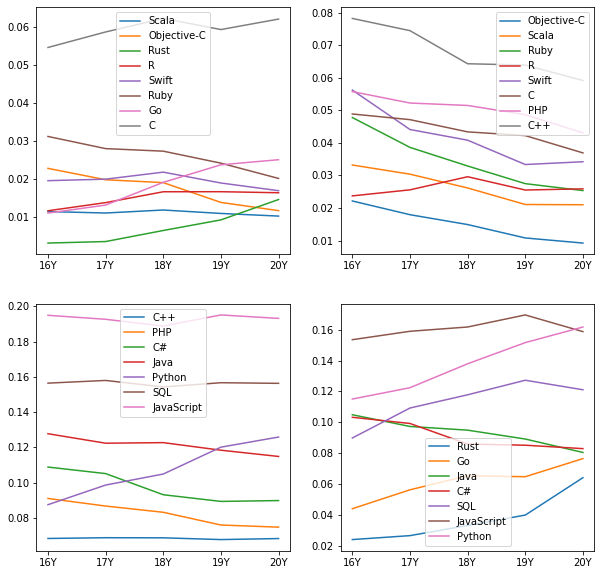

In [146]:
fig, axs = plt.subplots(2, 2)
df1[:8].T.plot(ax=axs[0,0], figsize=(10,10))
df1[8:].T.plot(ax=axs[1,0], figsize=(10,10))
df2[:8].T.plot(ax=axs[0,1], figsize=(10,10))
df2[8:].T.plot(ax=axs[1,1], figsize=(10,10))

In [20]:
df16['tech_do'].notna().sum()

49025

In [37]:
for d in [df13, df14]:
    names = {}
    for c in d.columns:
        values = d[c].value_counts()
        if 'Unnamed' in c and values.count() == 1:
            names[c] = values.index[0]
    d.rename(columns=names, inplace=True)
print(df13['C++'])
print(df14['Python'])

0       C++
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
9738    C++
9739    NaN
9740    C++
9741    NaN
9742    NaN
Name: C++, Length: 9743, dtype: object
0       Python
1       Python
2          NaN
3          NaN
4          NaN
         ...  
7639    Python
7640       NaN
7641       NaN
7642       NaN
7643       NaN
Name: Python, Length: 7644, dtype: object


In [38]:
df14.columns[20:]

Index(['In an average week, how do you spend your time at work?',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28',
       'What is your involvement in purchasing products or services for the company you work for? (You can choose more than one)',
       'I influence purchasing decisions, but don't have final approval',
       'I have a discretionary budget at my disposal',
       'I can buy anything I want without asking anyone', 'No Involvement',
       'What types of purchases are you involved in?', 'Servers', 'Software',
       'User Equipment: Monitors, PCs, Laptops', 'Consultants',
       'Recruitment Tools & Services', 'Other',
       'What is your budget for outside expenditures (hardware, software, consulting, etc) for 2014?',
       'Which of the following languages or technologies have you used significantly in the past year?',
       'C++', 'C#', 'Java', 'JavaScript', 'Node.js', 'Objective-C'

In [39]:
print(df15.loc[0:5, 'Unnamed: 0' : 'Unnamed: 55'])

  Unnamed: 0 Unnamed: 1 Unnamed: 2      Unnamed: 3  \
0    Country        Age     Gender  Tabs or Spaces   
1    Croatia      25-29       Male            Tabs   
2     France      20-24       Male          Spaces   
3      India      20-24       Male            Tabs   
4     Latvia      25-29       Male      It depends   
5     Norway      30-34       Male            Tabs   

                          Unnamed: 4              Unnamed: 5  \
0  Years IT / Programming Experience              Occupation   
1                        2 - 5 years  Back-end web developer   
2                        1 - 2 years  Back-end web developer   
3                        1 - 2 years  Back-end web developer   
4                       6 - 10 years  Back-end web developer   
5                        2 - 5 years  Back-end web developer   

                 Unnamed: 6                          Unnamed: 7  \
0  Desktop Operating System  Desktop Operating System: write-in   
1                    Ubuntu           

In [40]:
print(df15.loc[0:5, 'Select all that apply' : 'Unnamed: 55'])

          Select all that apply                    Unnamed: 9  \
0  Current Lang & Tech: Android  Current Lang & Tech: Arduino   
1                           NaN                           NaN   
2                           NaN                           NaN   
3                           NaN                           NaN   
4                           NaN                           NaN   
5                           NaN                           NaN   

                      Unnamed: 10             Unnamed: 11  \
0  Current Lang & Tech: AngularJS  Current Lang & Tech: C   
1                             NaN                     NaN   
2                             NaN                     NaN   
3                             NaN                     NaN   
4                             NaN                     NaN   
5                             NaN                     NaN   

                Unnamed: 12                 Unnamed: 13  \
0  Current Lang & Tech: C++  Current Lang & Tech: C++11  

In [41]:
print(df16['tech_do'].value_counts(), df16['tech_want'].value_counts())
print(df19.value_counts(subset=['LanguageDesireNextYear', 'LanguageWorkedWith']))

Java                                                                                                              843
C#                                                                                                                606
C#; JavaScript; SQL; SQL Server                                                                                   561
Android; Java                                                                                                     515
Python                                                                                                            501
                                                                                                                 ... 
Arduino / Raspberry Pi; Cloud (AWS, GAE, Azure, etc.); JavaScript; Node.js; Python; ReactJS; SQL                    1
Android; Java; JavaScript; Perl; Python; Ruby; SQL                                                                  1
Android; AngularJS; Cordova; iOS; Java; JavaScript; Mong

In [42]:
for d in [df17, df18, df19, df20]:
    counts = {}
    for worked in d['LanguageWorkedWith']:
        if pd.isna(worked):
            continue
        for l in worked.split(';'):
            if l in counts:
                counts[l] += 1
            else:
                counts[l] = 1
    print(d)

KeyError: 'LanguageWorkedWith'

A quick look through data, allows us to create a list of all of the individual methods marked by a user.

In [6]:
#Now we want to see how often each of these individual values appears - I wrote 
# this function to assist with process - it isn't the best solution, but it gets
# the job done and our dataset isn't large enough to computationally hurt us too much.

def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]
    
    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up 
    '''
    new_df = defaultdict(int)
    for val in look_for:
        for idx in range(df.shape[0]):
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])   
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df

In [7]:
# Now we can use our function and take a look at the results
# Looks like good news for Udacity - most individuals think that you 
# should take online courses


study_df = total_count(study, 'method', 'count', possible_vals)
study_df

,method,count
12,Take online courses,15246
1,Buy books and work through the exercises,11750
8,Part-time/evening courses,7517
3,Contribute to open source,7423
0,Bootcamp,5276
2,Conferences/meet-ups,5244
11,Return to college,5017
10,Participate in online coding competitions,3610
4,Get a job as a QA tester,3376
9,Participate in hackathons,2747


In [8]:
# We might also look at the percent

study_df['perc'] = study_df['count']/np.sum(study_df['count'])
study_df

,method,count,perc
12,Take online courses,15246,0.209432
1,Buy books and work through the exercises,11750,0.161408
8,Part-time/evening courses,7517,0.103260
3,Contribute to open source,7423,0.101968
0,Bootcamp,5276,0.072476
2,Conferences/meet-ups,5244,0.072036
11,Return to college,5017,0.068918
10,Participate in online coding competitions,3610,0.049590
4,Get a job as a QA tester,3376,0.046376
9,Participate in hackathons,2747,0.037735


We might want to take this one step further and say we care more about the methods that are suggested by those who earn more, or those who have higher job satisfaction.  Let's take a stab at incorporating that into this analysis.

In [9]:
# let's rewrite part of this function to get the mean salary for each method

def mean_amt(df, col_name, col_mean, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col_name - the column name you want to look through
    col_count - the column you want to count values from
    col_mean - the column you want the mean amount for
    look_for - a list of strings you want to search for in each row of df[col]
    
    OUTPUT:
    df_all - holds sum, square, total, mean, variance, and standard deviation for the col_mean
    '''
    new_df = defaultdict(int)
    squares_df = defaultdict(int)
    denoms = dict()
    for val in look_for:
        denoms[val] = 0
        for idx in range(df.shape[0]):
            if df[col_name].isnull()[idx] == False:
                if val in df[col_name][idx] and df[col_mean][idx] > 0:
                    new_df[val] += df[col_mean][idx]
                    squares_df[val] += df[col_mean][idx]**2 #Needed to understand the spread
                    denoms[val] += 1 
    
    # Turn into dataframes
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    squares_df = pd.DataFrame(pd.Series(squares_df)).reset_index()
    denoms = pd.DataFrame(pd.Series(denoms)).reset_index()
    
    # Change the column names
    new_df.columns = [col_name, 'col_sum']
    squares_df.columns = [col_name, 'col_squares']
    denoms.columns = [col_name, 'col_total']
    
    # Merge dataframes
    df_means = pd.merge(new_df, denoms)
    df_all = pd.merge(df_means, squares_df)
    
    # Additional columns needed for analysis
    df_all['mean_col'] = df_means['col_sum']/df_means['col_total']
    df_all['var_col'] = df_all['col_squares']/df_all['col_total'] - df_all['mean_col']**2
    df_all['std_col'] = np.sqrt(df_all['var_col'])
    df_all['lower_95'] = df_all['mean_col'] - 1.96*df_all['std_col']/np.sqrt(df_all['col_total'])
    df_all['upper_95'] = df_all['mean_col'] + 1.96*df_all['std_col']/np.sqrt(df_all['col_total'])
    return df_all

In [10]:
df_all = mean_amt(df, 'CousinEducation', 'Salary', possible_vals)

# To get a simple answer to our questions - see these two tables.

df_all.sort_values('mean_col', ascending=False)

,CousinEducation,col_sum,col_total,col_squares,mean_col,var_col,std_col,lower_95,upper_95
3,Contribute to open source,1.392267e+08,2253,1.239062e+13,61796.145495,1.680845e+09,40998.103671,60103.214545,63489.076445
7,Other,4.491415e+07,738,3.851360e+12,60859.281694,1.514792e+09,38920.331073,58051.234411,63667.328977
5,Master's degree,4.284612e+07,721,3.771773e+12,59425.969277,1.699862e+09,41229.387609,56416.462517,62435.476037
11,Return to college,8.733691e+07,1474,7.243713e+12,59251.636145,1.403567e+09,37464.208781,57339.037276,61164.235014
0,Bootcamp,9.583229e+07,1622,8.502989e+12,59082.794998,1.751510e+09,41851.043917,57046.048671,61119.541325
9,Participate in hackathons,4.641498e+07,796,4.044473e+12,58310.277060,1.680908e+09,40998.879264,55462.070236,61158.483884
2,Conferences/meet-ups,9.699603e+07,1677,8.366275e+12,57839.015307,1.643482e+09,40539.886446,55898.701080,59779.329533
4,Get a job as a QA tester,5.852363e+07,1032,5.017250e+12,56708.940771,1.645773e+09,40568.122771,54233.792987,59184.088555
1,Buy books and work through the exercises,1.909928e+08,3393,1.624985e+13,56290.232211,1.620639e+09,40257.160560,54935.644033,57644.820390
12,Take online courses,2.415638e+08,4493,2.011544e+13,53764.488012,1.586442e+09,39830.167883,52599.825762,54929.150262


In [11]:
study_df

,method,count,perc
12,Take online courses,15246,0.209432
1,Buy books and work through the exercises,11750,0.161408
8,Part-time/evening courses,7517,0.103260
3,Contribute to open source,7423,0.101968
0,Bootcamp,5276,0.072476
2,Conferences/meet-ups,5244,0.072036
11,Return to college,5017,0.068918
10,Participate in online coding competitions,3610,0.049590
4,Get a job as a QA tester,3376,0.046376
9,Participate in hackathons,2747,0.037735


Although we can see the mean salary is highest for the individuals who say that you should contribute to open source, you might be asking - is that really a significant difference?  The salary differences don't see that large...

By the Central Limit Theorem, we know that the mean of any set of data will follow a normal distribution with a standard deviation equal to the standard deviation of the original data divided by the square root of the sample size, as long as we collect a large enough sample size.  With that in mind, we can consider two salaries significantly different if a second salary is two standard deviations or more away from the other.

Using the lower and upper bound components, we can get an idea of the salaries that are significantly different from one another.   

In [12]:
# Quiz - perform a similar analysis looking at career and job satisfaction for this individuals
# to determine which you want to be like

In [15]:
df_jobsat = mean_amt(df, 'CousinEducation', 'JobSatisfaction', possible_vals)

In [16]:
df_jobsat.sort_values('mean_col', ascending=False)

,CousinEducation,col_sum,col_total,col_squares,mean_col,var_col,std_col,lower_95,upper_95
9,Participate in hackathons,14884.0,2073,115166.0,7.179932,4.003804,2.000951,7.093795,7.266070
7,Other,13797.0,1937,106521.0,7.122870,4.257489,2.063368,7.030980,7.214760
11,Return to college,27767.0,3904,212971.0,7.112449,3.965070,1.991248,7.049985,7.174912
4,Get a job as a QA tester,21294.0,3000,162716.0,7.098000,3.857063,1.963941,7.027721,7.168279
3,Contribute to open source,42374.0,5999,324340.0,7.063511,4.172496,2.042669,7.011820,7.115202
2,Conferences/meet-ups,30868.0,4371,236106.0,7.062000,4.144635,2.035838,7.001645,7.122354
0,Bootcamp,30404.0,4307,231670.0,7.059206,3.956792,1.989169,6.999799,7.118613
1,Buy books and work through the exercises,66788.0,9492,508944.0,7.036241,4.109517,2.027194,6.995459,7.077023
8,Part-time/evening courses,42797.0,6100,324829.0,7.015902,4.027780,2.006933,6.965537,7.066266
12,Take online courses,85746.0,12222,651056.0,7.015709,4.049009,2.012215,6.980035,7.051384


In [26]:
pd.DataFrame(np.hstack([df_jobsat, df_all]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,Bootcamp,30404,4307,231670,7.05921,3.95679,1.98917,6.9998,7.11861,Bootcamp,9.58323e+07,1622,8.50299e+12,59082.8,1.75151e+09,41851,57046,61119.5
1,Buy books and work through the exercises,66788,9492,508944,7.03624,4.10952,2.02719,6.99546,7.07702,Buy books and work through the exercises,1.90993e+08,3393,1.62499e+13,56290.2,1.62064e+09,40257.2,54935.6,57644.8
2,Conferences/meet-ups,30868,4371,236106,7.062,4.14463,2.03584,7.00165,7.12235,Conferences/meet-ups,9.6996e+07,1677,8.36627e+12,57839,1.64348e+09,40539.9,55898.7,59779.3
3,Contribute to open source,42374,5999,324340,7.06351,4.1725,2.04267,7.01182,7.1152,Contribute to open source,1.39227e+08,2253,1.23906e+13,61796.1,1.68084e+09,40998.1,60103.2,63489.1
4,Get a job as a QA tester,21294,3000,162716,7.098,3.85706,1.96394,7.02772,7.16828,Get a job as a QA tester,5.85236e+07,1032,5.01725e+12,56708.9,1.64577e+09,40568.1,54233.8,59184.1
5,Master's degree,14459,2091,108711,6.91487,4.17448,2.04316,6.8273,7.00245,Master's degree,4.28461e+07,721,3.77177e+12,59426,1.69986e+09,41229.4,56416.5,62435.5
6,None of these,3000,433,22898,6.92841,4.8794,2.20894,6.72034,7.13647,None of these,5.37709e+06,112,4.27319e+11,48009.7,1.51042e+09,38864.1,40812,55207.4
7,Other,13797,1937,106521,7.12287,4.25749,2.06337,7.03098,7.21476,Other,4.49141e+07,738,3.85136e+12,60859.3,1.51479e+09,38920.3,58051.2,63667.3
8,Part-time/evening courses,42797,6100,324829,7.0159,4.02778,2.00693,6.96554,7.06627,Part-time/evening courses,1.12454e+08,2117,9.29078e+12,53119.6,1.56696e+09,39584.9,51433.4,54805.9
9,Participate in hackathons,14884,2073,115166,7.17993,4.0038,2.00095,7.09379,7.26607,Participate in hackathons,4.6415e+07,796,4.04447e+12,58310.3,1.68091e+09,40998.9,55462.1,61158.5


In [24]:
pd.DataFrame?

In [27]:
df_jobsat.col_total

0      4307
1      9492
2      4371
3      5999
4      3000
5      2091
6       433
7      1937
8      6100
9      2073
10     2675
11     3904
12    12222
Name: col_total, dtype: int64

In [70]:
df_dotplot = pd.DataFrame(np.array(['Method', "At least Master's", "Less Than Master's", 
"Master's Degree",0.0589517,0.0293459,
"Bootcamp",0.0746172,0.071824,
"Become QA Tester",0.0484688,0.0457388,
"Buy Books",0.162073,0.161205,
"None of these",0.00836278,0.00827705,
"Part Time Courses",0.103298,0.103248,
"Return to College",0.0687279,0.0689754,
"Online Courses",0.207892,0.2099,
"Contribute to Opensource",0.097821,0.10323,
"Coding Competitions",0.0453475,0.0508806,
"Other",0.0269729,0.0338607,
"Hackathons", 0.0316254,0.0395937,
"Conferences", 0.0658422, 0.0739201]).reshape((14, 3)))

In [71]:
df_dotplot.columns = df_dotplot.iloc[0]

In [72]:
df_dotplot.drop(0, inplace=True)

In [42]:
import seaborn as sns

In [ ]:
df_dotplot.prop = df_dotplot.prop.astype(float)

In [48]:
df_dotplot = df_dotplot.melt(id_vars='Method', value_name='prop', var_name='status')

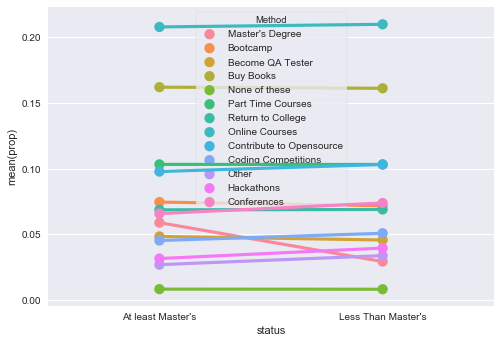

In [69]:
sns.pointplot(data=df_dotplot, x='status', y='prop', hue='Method');


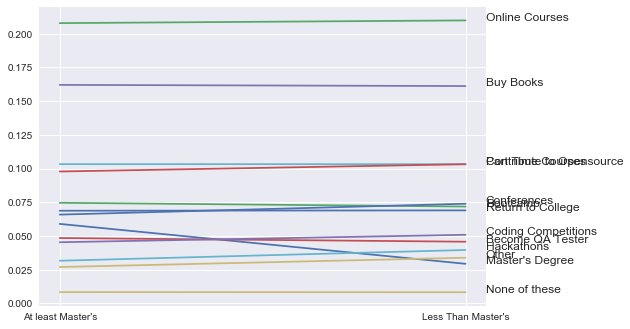

In [77]:
for idx, row in df_dotplot.iterrows():
    plt.plot([0,1],[row["At least Master's"], row["Less Than Master's"]]);
    plt.text(1.05, row["Less Than Master's"], row['Method']);
plt.xticks([0,1], ["At least Master's", "Less Than Master's"]);

In [75]:
for row in df_dotplot:
    print(row)

Method
At least Master's
Less Than Master's
